In [54]:
import numpy as np
import pandas as pd

np.set_printoptions(precision=3, linewidth=150)
pd.set_option('precision', 3)

xsL = [(0,1),(0,1),]
qs  = (0,1,)

if False:
    ys  = ((0,0), (0,1), (1,0), (1,1))

    pX0X1 = np.array([[1, 0.1],[0.2,1]]).astype('float')
    #pX0X1 = np.eye(2)
    pX0X1 /= pX0X1.sum()

    pXY = {}
    for xix, xs in enumerate(xsL):
        pXY[xix] = np.zeros((len(xs),len(ys)))
        for xndx, x in enumerate(xs):
            for yndx, y in enumerate(ys):
                if y[xix] == x:
                    pXY[xix][xndx,yndx] = pX0X1[y[0],y[1]]
                    #print('h x%d=%d y=%s'%(xix, x, y),  y[0],y[1])
        pXY[xix]/=pXY[xix].sum()

    pY = pXY[0].sum(axis=0)
    # print(pY)
    assert(np.allclose(pY, pXY[1].sum(axis=0)))

else:
    ys  = (0,1,2)
    
    pYX0X1 = np.random.random((len(ys),len(xsL[0]),len(xsL[1])))
    pYX0X1 /= pYX0X1.sum()
    
    pY = pYX0X1.sum(axis=-1).sum(axis=-1)
    pXY= {}
    pXY[0] = pYX0X1.sum(axis=-1).T
    pXY[1] = pYX0X1.sum(axis=1).T
assert(np.allclose(pY, pXY[0].sum(axis=0)))
assert(np.allclose(pY, pXY[1].sum(axis=0)))


In [55]:
ixs = {}
names = {}
for q in qs:
    for y in ys:
        k= ('q|y',q,y)
        ixs[k] = len(ixs)
        names[k] = 'p(Q=%d|Y=%s)' % (q,str(y))
for xix, xs in enumerate(xsL):
    for q in qs: # [:-1]:
        for x in xs:
            k = ('q|x%d'%xix,q,x)
            ixs[k] = len(ixs)
            names[k] = 'p(Q=%d|X%d=%d)' % (q,xix,x)
N = len(ixs)

In [56]:
A = []
for q in qs[:-1]:
    for xix, xs in enumerate(xsL):
        for x in xs:
            r = np.zeros(N)
            r[ixs[('q|x%d'%xix,q,x)]] = 1
            A.append(r)
            

for xix, xs in enumerate(xsL):
    for x in xs:
        r = np.zeros(N)
        for q in qs:
            r[ixs[('q|x%d'%xix,q,x)]] = 1
        A.append(r)

B = []

for yndx, y in enumerate(ys):
    r = np.zeros(N)
    for q in qs:
        r[ixs[('q|y',q,y)]] = 1
    B.append(r)

for xix, xs in enumerate(xsL):
    for xndx, x in enumerate(xs):
        r = np.zeros(N)
        for q in qs:
            r[ixs[('q|x%d'%xix,q,x)]] = 1
        B.append(r)
            
    for q in qs[:-1]:
        for yndx, y in enumerate(ys):
            r = np.zeros(N)
            #r = np.zeros(N).astype('str')
            cval = -pY[yndx]
            #cval = 'pY(%d)'%yndx
            if q == qs[-1]:
                cval *= -1
                for q2 in qs[:-1]:
                    r[ixs[('q|y',q2,y)]] = cval
            else:
                # cval = '-'+cval
                r[ixs[('q|y',q,y)]] = cval
                
            for xndx, x in enumerate(xs):
                cval = pXY[xix][xndx,yndx]
                if q == qs[-1]:
                    for q2 in qs[:-1]:
                        r[ixs[('q|x%d'%xix,q2,x)]] = cval
                else:
                        r[ixs[('q|x%d'%xix,q,x)]] = cval
            B.append(r)
            
Amx = np.array(A)
Bmx = np.array(B)
Cmx = np.vstack([A,B])
print('shape(A) = %s, rank(A) = %d' % (Amx.shape,np.linalg.matrix_rank(Amx)))
print('shape(B) = %s, rank(B) = %d' % (Bmx.shape,np.linalg.matrix_rank(Bmx)))
print('shape(C) = %s, rank(C) = %d' % (Cmx.shape,np.linalg.matrix_rank(Cmx)))



cols = ['-',]*len(ixs)
for k,v in ixs.items():
    cols[v] = names[k]
df = pd.DataFrame(Bmx.copy(), columns=cols)
df[df==0] = '.'
df


shape(A) = (8, 14), rank(A) = 8
shape(B) = (13, 14), rank(B) = 13
shape(C) = (21, 14), rank(C) = 14


,p(Q=0|Y=0),p(Q=0|Y=1),p(Q=0|Y=2),p(Q=1|Y=0),p(Q=1|Y=1),p(Q=1|Y=2),p(Q=0|X0=0),p(Q=0|X0=1),p(Q=1|X0=0),p(Q=1|X0=1),p(Q=0|X1=0),p(Q=0|X1=1),p(Q=1|X1=0),p(Q=1|X1=1)
0,1,.,.,1,.,.,.,.,.,.,.,.,.,.
1,.,1,.,.,1,.,.,.,.,.,.,.,.,.
2,.,.,1,.,.,1,.,.,.,.,.,.,.,.
3,.,.,.,.,.,.,1,.,1,.,.,.,.,.
4,.,.,.,.,.,.,.,1,.,1,.,.,.,.
5,-0.295,.,.,.,.,.,0.162,0.133,.,.,.,.,.,.
6,.,-0.458,.,.,.,.,0.14,0.318,.,.,.,.,.,.
7,.,.,-0.247,.,.,.,0.146,0.101,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.,.,1,.,1,.
9,.,.,.,.,.,.,.,.,.,.,.,1,.,1


In [57]:

print(Bmx.sum(axis=1))

asfasfd
#print(Bmx[:6].sum(axis=0))

#fit = np.linalg.lstsq(Bmx[:10].T, Bmx[11])
fit = np.linalg.solve(Bmx[1:5,1:5].T, Bmx[0,1:5])
print(fit.dot(Bmx[1:5,1:5]), Bmx[0,1:5])
asdf

print(fit)
print(fit[1])
fit[0][np.isclose(fit[0],0)]=0
print(fit[0])

[ 2.000e+00  2.000e+00  2.000e+00  2.000e+00  2.000e+00  0.000e+00  0.000e+00  0.000e+00  2.000e+00  2.000e+00  0.000e+00 -5.551e-17  2.776e-17]


NameError: name 'asfasfd' is not defined

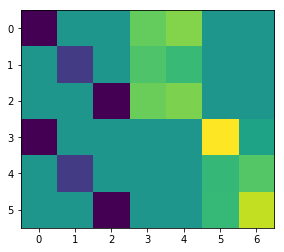

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(Bmx)
plt.show()